# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../data/')
sys.path.append('../modelling/')

In [2]:
import player_data as player
import goodness_fit
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, mean_absolute_error
import patsy

/home/tom/footbot/venv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
response_variable = 'clean_sheets_no_time'

# Get data

In [4]:
file_name = 'csvs/element_gameweek_' + datetime.today().strftime('%Y-%m-%d') + '.csv'

In [5]:
try:
    element_gameweek_df = pd.read_csv(file_name)
except:
    element_gameweek_df = player.get_element_gameweek_df()
    element_gameweek_df.to_csv(file_name)

In [6]:
current_event = 32
element_types = [1, 2, 3, 4]
threshold_minutes = 1

In [7]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
    & (element_gameweek_df['element_type'].isin(element_types))
    & (element_gameweek_df['minutes'] >= threshold_minutes)
]

In [8]:
player.add_home_categorical_variable(element_gameweek_df)

In [9]:
element_gameweek_df['clean_sheets_no_time'] =\
element_gameweek_df['goals_conceded'].apply(lambda x: 1 if x == 0 else 0)

In [10]:
element_gameweek_df['row_id'] = element_gameweek_df['row_id'].rank()

In [11]:
element_gameweek_df['element_fixture_rank'] = element_gameweek_df.groupby('element')['row_id'].rank()

In [12]:
rolling_df = \
element_gameweek_df.copy().groupby('element', as_index=True)[['minutes', 'goals_conceded']]\
.rolling(38, min_periods=1).sum().reset_index()[['element', 'minutes', 'goals_conceded']]

In [13]:
rolling_df['element_fixture_rank'] = rolling_df.groupby('element')['minutes'].rank()

In [14]:
rolling_df['element_fixture_rank'] = rolling_df['element_fixture_rank'] + 1

In [15]:
element_gameweek_df =\
element_gameweek_df.join(
    rolling_df.set_index(['element', 'element_fixture_rank']),
    on=['element', 'element_fixture_rank'],
    rsuffix='_rolling')

In [16]:
element_gameweek_df['goals_conceded_per_minute_rolling'] = \
element_gameweek_df['goals_conceded_rolling'] / element_gameweek_df['minutes_rolling']

In [17]:
rolling_p5_df = \
element_gameweek_df.copy().groupby('element', as_index=True)[['minutes', 'goals_conceded']]\
.rolling(5, min_periods=1).sum().reset_index()[['element', 'minutes', 'goals_conceded']]

In [18]:
rolling_p5_df['element_fixture_rank'] = rolling_p5_df.groupby('element')['minutes'].rank()

In [19]:
rolling_p5_df['element_fixture_rank'] = rolling_p5_df['element_fixture_rank'] + 1

In [20]:
element_gameweek_df =\
element_gameweek_df.join(
    rolling_p5_df.set_index(['element', 'element_fixture_rank']),
    on=['element', 'element_fixture_rank'],
    rsuffix='_rolling_p5')

In [21]:
element_gameweek_df['goals_conceded_per_minute_rolling_p5'] = \
element_gameweek_df['goals_conceded_rolling_p5'] / element_gameweek_df['minutes_rolling_p5']

In [22]:
element_gameweek_df.head()

,row_id,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,...,own_team,opposition_team,clean_sheets_no_time,element_fixture_rank,minutes_rolling,goals_conceded_rolling,goals_conceded_per_minute_rolling,minutes_rolling_p5,goals_conceded_rolling_p5,goals_conceded_per_minute_rolling_p5
0,1.0,0,42,0,0,0,24,0,2,31,...,1,13,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,0,35,0,0,0,26,0,1,25,...,1,6,0,2.0,90.0,2.0,0.022222,90.0,2.0,0.022222
2,3.0,0,24,0,0,0,17,0,0,20,...,1,19,0,3.0,180.0,5.0,0.027778,180.0,5.0,0.027778
3,4.0,0,38,0,0,0,8,0,0,24,...,1,5,0,4.0,270.0,6.0,0.022222,270.0,6.0,0.022222
4,5.0,0,33,0,0,0,13,0,2,23,...,1,15,0,5.0,360.0,8.0,0.022222,360.0,8.0,0.022222


In [23]:
element_gameweek_df.columns

Index(['row_id', 'assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'completed_passes', 'creativity',
       'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
       'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
       'goals_scored', 'ict_index', 'id', 'influence', 'key_passes',
       'kickoff_time', 'kickoff_time_formatted', 'loaned_in', 'loaned_out',
       'minutes', 'offside', 'open_play_crosses', 'opponent_team', 'own_goals',
       'penalties_conceded', 'penalties_missed', 'penalties_saved',
       'recoveries', 'red_cards', 'round', 'saves', 'selected', 'tackled',
       'tackles', 'target_missed', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'winning_goals', 'yellow_cards', 'event', 'team_a',
       'team_a_difficulty', 'team_h', 'team

# Models

## Helpers

In [58]:
def get_all_columns(formula, df):
    return patsy.dmatrices(formula, df, return_type='dataframe')[1].columns

def add_missing_columns(df, columns):
    for col in set(columns) - set(df.columns):
        df[col] = np.zeros(len(df))
    
    return df[columns]

def classify_probability(p, threshold):
    if p >= threshold:
        return 1
    else:
        return 0

In [59]:
def kfold_cross_validation(formula, df, splits, threshold=0.5):
    columns = get_all_columns(formula, df)
    
    folds = []
    
    for train_index, test_index in KFold(n_splits=splits, shuffle=True).split(df):
        folds.append((df.iloc[train_index], df.iloc[test_index]))
    
    eval_metrics = []
    for f in folds:
        try:
            response_train, explanatory_train = patsy.dmatrices(formula, f[0], return_type='dataframe')
            explanatory_train = add_missing_columns(explanatory_train, columns)
            
            response_test, explanatory_test = patsy.dmatrices(formula, f[1], return_type='dataframe')
            explanatory_test = add_missing_columns(explanatory_test, columns)
            
            model = sm.GLM(response_train, explanatory_train, family=sm.families.Binomial(), missing='drop').fit()
            reponse_test_pred = model.predict(explanatory_test)
            reponse_train_pred = model.predict(explanatory_train)
            reponse_test_pred_class = [classify_probability(i, threshold) for i in reponse_test_pred]
            reponse_train_pred_class = [classify_probability(i, threshold) for i in reponse_train_pred]

            precision_score_test = precision_score(response_test, reponse_test_pred_class)
            precision_score_train = precision_score(response_train, reponse_train_pred_class)
            recall_score_error_test = recall_score(response_test, reponse_test_pred_class)
            recall_score_train = recall_score(response_train, reponse_train_pred_class)
            mean_absolute_error_test = mean_absolute_error(response_test, reponse_test_pred)
            mean_absolute_error_train = mean_absolute_error(response_train, reponse_train_pred)

            m = {
                'precision_score_test': precision_score_test,
                'precision_score_train': precision_score_train,
                'recall_score_error_test': recall_score_error_test,
                'recall_score_train': recall_score_train,
                'mean_absolute_error_test': mean_absolute_error_test,
                'mean_absolute_error_train': mean_absolute_error_train,
            }

            eval_metrics.append(m)
        except Exception as e:
            print(e)
            
    return pd.DataFrame(eval_metrics)

In [60]:
def n_kfold_cross_validation(formula, df, splits, n, threshold=0.5):
    eval_metrics_arr = []
    for i in range(0, n):
        print('iteration ', i + 1)
        eval_metrics_arr.append(kfold_cross_validation(formula, df, splits, threshold))
    
    eval_metrics = pd.concat(eval_metrics_arr)
    return pd.DataFrame(eval_metrics)

## Binomial teams minutes model

In [61]:
sptmm_df = element_gameweek_df.copy()

In [62]:
sptmm_formula = \
f'{response_variable} ~ np.log(minutes) + C(element_type) + C(own_team) + C(opposition_team) + was_home'

In [63]:
sptmm_eval_df = n_kfold_cross_validation(sptmm_formula, sptmm_df, 10, 10)

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10


In [77]:
sptmm_eval_df['model'] = 'Binomial teams minutes'
sptmm_eval = sptmm_eval_df.groupby('model').mean()
sptmm_eval

,mean_absolute_error_test,mean_absolute_error_train,precision_score_test,precision_score_train,recall_score_error_test,recall_score_train
model,,,,,,
Binomial teams minutes,0.357471,0.355633,0.706514,0.711638,0.46875,0.472928


## Binomial teams minutes form model

In [65]:
sptmmf_df = element_gameweek_df.copy()

In [66]:
sptmmf_formula = \
f'{response_variable} ~ np.log(minutes) + C(element_type) + C(own_team) + C(opposition_team) + was_home + goals_conceded_per_minute_rolling'

In [67]:
sptmmf_eval_df = n_kfold_cross_validation(sptmmf_formula, sptmmf_df, 10, 10)

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10


In [78]:
sptmmf_eval_df['model'] = 'Binomial teams minutes form'
sptmmf_eval = sptmmf_eval_df.groupby('model').mean()
sptmmf_eval

,mean_absolute_error_test,mean_absolute_error_train,precision_score_test,precision_score_train,recall_score_error_test,recall_score_train
model,,,,,,
Binomial teams minutes form,0.35594,0.353981,0.702463,0.708155,0.463129,0.468239


## Binomial players minutes model

In [69]:
sppmm_df = element_gameweek_df.copy()

In [70]:
sppmm_formula = \
f'{response_variable} ~ np.log(minutes) + C(element) + C(opposition_team) + was_home'

In [71]:
sppmm_eval_df = n_kfold_cross_validation(sppmm_formula, sppmm_df, 10, 1)

iteration  1


In [79]:
sppmm_eval_df['model'] = 'Binomial players minutes'
sppmm_eval = sppmm_eval_df.groupby('model').mean()
sppmm_eval

,mean_absolute_error_test,mean_absolute_error_train,precision_score_test,precision_score_train,recall_score_error_test,recall_score_train
model,,,,,,
Binomial players minutes,0.35385,0.330522,0.650892,0.716437,0.493973,0.547345


# Model comparison

In [80]:
pd.concat([
    sptmm_eval,
    sptmmf_eval,
    sppmm_eval,
]).round(3)

,mean_absolute_error_test,mean_absolute_error_train,precision_score_test,precision_score_train,recall_score_error_test,recall_score_train
model,,,,,,
Binomial teams minutes,0.357,0.356,0.707,0.712,0.469,0.473
Binomial teams minutes form,0.356,0.354,0.702,0.708,0.463,0.468
Binomial players minutes,0.354,0.331,0.651,0.716,0.494,0.547


# Changing classification threshold

In [84]:
threshold_arr = np.linspace(0, 0.9, 10)

## Binomial teams minutes model

In [85]:
eval_df_arr = []
for i in threshold_arr:
    print(i)
    eval_df = kfold_cross_validation(sptmm_formula, sptmm_df, 10, i)
    eval_df['threshold'] = [i] * len(eval_df)
    eval_df_arr.append(eval_df)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


In [86]:
eval_df = pd.concat(eval_df_arr)
df = eval_df.groupby('threshold').mean()
df

,mean_absolute_error_test,mean_absolute_error_train,precision_score_test,precision_score_train,recall_score_error_test,recall_score_train
threshold,,,,,,
0.0,0.357309,0.355649,0.363127,0.363122,1.000000,1.000000
0.1,0.357288,0.355648,0.394341,0.395001,0.993115,0.993421
0.2,0.357595,0.355622,0.458095,0.461394,0.906942,0.916018
0.3,0.357615,0.355622,0.530678,0.534207,0.755447,0.760827
0.4,0.357665,0.355618,0.623980,0.631595,0.608178,0.614292
0.5,0.357614,0.355614,0.705760,0.711946,0.467255,0.473097
0.6,0.357466,0.355628,0.755222,0.759058,0.344625,0.347287
0.7,0.357521,0.355638,0.814314,0.817723,0.245688,0.245920
0.8,0.357320,0.355647,0.862907,0.866004,0.157675,0.158776


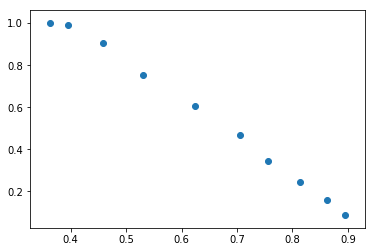

In [88]:
plt.scatter(df['precision_score_test'], df['recall_score_error_test'])
plt.show()